In [1]:
import os
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,utils
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class FaceDataset(Dataset):
    def __init__(self, csv_file, txt_file, root_dir, transform=None):
        self.index = pd.read_csv(csv_file)
        self.labels = np.loadtxt(txt_file)[:,3]
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir, self.index.iloc[idx, 0])
        image = io.imread(img_name)
        image = image.astype('float')
        labels = self.labels[idx]
        labels = labels.astype('long').reshape(-1)
        sample = {'image':image, 'label':labels}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = np.transpose(image, (2, 0, 1))
        label = (label + 1) / 2
        return {'image':torch.FloatTensor(image),
                 'label':torch.LongTensor(label)}

In [3]:
transformed_dataset = FaceDataset(csv_file='img/label.csv', txt_file='img/labelss.txt',
                                  root_dir='img/', transform=transforms.Compose([
    ToTensor()
]))
train_size = 4500
test_size = 500
batch_size = 150
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)
train_dataset, test_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)

(3, 218, 178)
(218, 178)


D:\Anaconda\envs\lab1\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[1]')

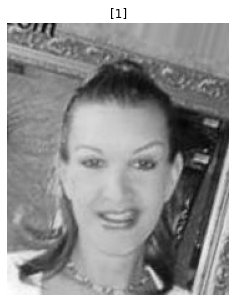

In [4]:
#check if the dictionary is correct
#print(transformed_dataset[0])
#print(transformed_dataset[1])
#print(transformed_dataset[2])
#print(train_dataset[0]['label'])
#print(train_dataset[0]['image'])
Image = np.array(train_dataset[345]['image'])
Label = np.array(train_dataset[345]['label'])
print(Image.shape)
#to check if the label is corresponding to the image
plt.rcParams['figure.figsize'] = (5,5)
#img = Image
img = np.mean(Image, axis=0) / 255.
print(img.shape)
#dim_x, dim_y =Image.shape
#print("The images have dimensions:", dim_x, "x", dim_y)#图片长宽像素
#print("Total number of pixels:", dim_x*dim_y)
plt.imshow(img, cmap="gray")
#plt.imshow(img)
plt.axis("off")
plt.title(Label)

In [5]:
# 建立卷积神经网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 20, 4, 1)
        self.conv3 = nn.Conv2d(20, 50, 3, 1)
        self.fc1 = nn.Linear(25*20*50, 10000)
        self.fc2 = nn.Linear(10000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 25*20*50)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x,dim=1)

In [6]:
# 设置参数、模型、优化器
lr = 1
momentum = 0.5
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
num_epochs = 1

In [9]:
# 训练函数
def train(model, train_loader, optimizer, epoch):
    model.train()
    for idx, sample in enumerate(train_loader): # idx:字典的批序号，sample:第idx批字典
        data = sample['image'] # data:tensor格式float32, 30 * 3 * 94 * 94
        target = sample['label'].view(-1) # target:tensor格式， 30 * 1
        data = torch.tensor(data, dtype=torch.float32)
        pred = model(data) # pred:tensor格式， 30 * 1
        loss = F.nll_loss(pred, target) # loss:tensor格式标量
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #torch.save(the_model,'D:/ELEC0134 Applied Machine Learning Systems/assignment/AMLS_assignment_kit/AMLS_20-21_SN12345678/A2')
        print("Train Epoch:{}, iteration:{}, Loss:{}".format(epoch, idx, loss.item()))

In [10]:
# 测试函数
def test(model, test_loader):
    model.eval()
    total_loss = 0.
    correct = 0.
    with torch.no_grad():
        for idx, sample in enumerate(test_loader): # idx:字典的批序号，sample:第idx批字典
            data = sample['image'] # data:tensor格式float32, 1 * 3 * 94 * 94
            target = sample['label'].view(-1) # target:tensor格式标量
            data = torch.tensor(data, dtype=torch.float32)
            output = model(data) # output:tensor格式标量
            total_loss = F.nll_loss(output, target, reduction = 'sum').item() # total_loss:tensor格式标量
            pred = output.argmax(dim = 1)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    total_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset) * 100
    print("Test Loss:{}, Test Accuracy:{}".format(total_loss, acc))

In [11]:
for epoch in range(num_epochs):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
torch.save(model, 'smiling.pt')

D:\Anaconda\envs\lab1\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Train Epoch:0, iteration:0, Loss:0.7252987027168274
Train Epoch:0, iteration:1, Loss:37.93602752685547
Train Epoch:0, iteration:2, Loss:7.713013648986816
Train Epoch:0, iteration:3, Loss:0.8248280882835388
Train Epoch:0, iteration:4, Loss:1.1820451021194458
Train Epoch:0, iteration:5, Loss:1.1908962726593018
Train Epoch:0, iteration:6, Loss:6272.13720703125
Train Epoch:0, iteration:7, Loss:96.9342269897461
Train Epoch:0, iteration:8, Loss:357499.75
Train Epoch:0, iteration:9, Loss:6693822464.0
Train Epoch:0, iteration:10, Loss:60635920.0
Train Epoch:0, iteration:11, Loss:2490712.25
Train Epoch:0, iteration:12, Loss:1255870720.0
Train Epoch:0, iteration:13, Loss:1300314849280.0
Train Epoch:0, iteration:14, Loss:3.124896154960709e+26
Train Epoch:0, iteration:15, Loss:4.157178074701064e+25
Train Epoch:0, iteration:16, Loss:3.878439833815199e+20
Train Epoch:0, iteration:17, Loss:1.459199264616874e+20
Train Epoch:0, iteration:18, Loss:0.7799457907676697
Train Epoch:0, iteration:19, Loss:0.6

D:\Anaconda\envs\lab1\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Test Loss:0.6949111938476562, Test Accuracy:51.4


D:\Anaconda\envs\lab1\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
